In [673]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from treelib import Node, Tree
import random
from graphviz import Source
import pydotplus
import logging
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

In [679]:
feature_names= ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
# load dataset
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']

pima = pd.read_csv("diabetes.csv", names=col_names)
x = pima[feature_names].values # Features
y = pima.label.values




In [680]:
x_train, x_test, y_train, y_test = train_test_split(  x, y, test_size=0.20, random_state=30)

In [678]:
x_train

array([[  3.   ,   0.   ,  34.4  , ...,  61.   ,  82.   ,   0.243],
       [  0.   ,   0.   ,  27.9  , ..., 105.   ,  84.   ,   0.741],
       [  8.   ,   0.   ,  43.3  , ..., 105.   , 100.   ,   0.239],
       ...,
       [  3.   ,   0.   ,  21.1  , ..., 128.   ,  78.   ,   0.268],
       [  2.   ,  71.   ,  25.2  , ..., 117.   ,  90.   ,   0.313],
       [  2.   ,  76.   ,  26.   , ...,  94.   ,  68.   ,   0.561]])

In [681]:
def entropy_cal(y_val):

    _, values = np.unique(y_val, return_counts=True)
    total_val =  np.sum(values)
    probability = values/total_val
        
    entropy = np.sum(- probability* np.log2(probability))

    return entropy, np.sum(values)


In [682]:
def total_entropy(left_truth, right_truth):

   all_values =  np.concatenate((left_truth,right_truth))
   _, values = np.unique(all_values, return_counts=True)
   size = len(all_values)
   probability =  values/size

   entropy = np.sum(- probability* np.log2(probability))

   return entropy, size 
    

In [648]:
def info_gain(total_entropy, left_entropy, right_entropy, l_app, r_app, total_size):
    
    info_gain = total_entropy - (l_app/ total_size)*left_entropy - (r_app/total_size)* right_entropy
    
    return info_gain

In [649]:
def is_unique(values,parent):
    global tree
  
    unique_values, total_count = np.unique(values, return_counts=True)

    if len(unique_values) ==  1 :
     tree.create_node(str(unique_values[0]),parent=parent)
     
     return True
    return False

In [650]:
def majority_vote(x,y):
    category, votes = np.unique(y,return_counts=True)
    max_votes = np.argmax(votes)
    return category[max_votes]

In [651]:
def data_divider(x,y,divider,column):
     

        left_truth= y[x[:,column]<=divider]
        right_truth = y[x[:,column]>divider]

        left_data= x[x[:,column]<=divider]
        right_data = x[x[:,column]>divider]
    
        
        return left_truth, right_truth, left_data, right_data

In [683]:
def best_divider(x,y):
    

    column_length = x.shape[1]

    deviders_all_max  = np.zeros(column_length)
    ig_holder_all = np.zeros(column_length)
     

    for j in range(column_length):
      
      new_x = x[:,j]
      new_y = y
      unqiue_data = np.unique(new_x)


      info_max_list = np.zeros(len(unqiue_data))
      info_divider_list  = np.zeros(len(unqiue_data))

      for i in range(0, len(unqiue_data)-1):
        if(i!=0):
         divider = (unqiue_data[i] +unqiue_data[i-1])/2.0
  
         left_truth, right_truth, left_data, right_data  = data_divider(x, new_y,divider, column=j)
       
        
         entropy_l, l_app = entropy_cal(left_truth)
         entropy_r, r_app = entropy_cal(right_truth)

         t_entropy, total_size =  total_entropy(left_truth, right_truth)
      


         gain = info_gain(t_entropy, entropy_l, entropy_r,l_app,r_app, total_size)

         
         info_max_list[i] = gain
         info_divider_list[i] = divider
       
       
     
    

      deviders_all_max[j] = info_divider_list[np.argmax(info_max_list)]
      ig_holder_all[j] = info_max_list[np.argmax(info_max_list)]
    

    deviders_all_max = deviders_all_max[np.argmax(ig_holder_all)]
    ig_holder_index = np.argmax(ig_holder_all)
      

    return  deviders_all_max, ig_holder_index

In [684]:

def Decision_Tree(x,y, feature_names, node ):
    global tree    


    if is_unique(y,node):
        return True
    
    deviders_all_max, ig_holder_index = best_divider(x,y)

    
    
 
    left_value_y, right_value_y, left_value, right_value = data_divider(x,y,deviders_all_max, column=ig_holder_index)

    if(len(left_value)<=0 or len(right_value)<=0):
     
            class_majority = majority_vote(x,y)
    
            temp = tree.create_node(str(class_majority),parent=node)
    
            node = temp
    
    
    else:
        node_name = str(feature_names[ig_holder_index])+" <= "+str(deviders_all_max) +""
    
        temp_two = tree.create_node(str(node_name),parent=node)
        node =  temp_two

        Decision_Tree(left_value, left_value_y, feature_names, node)
        
        Decision_Tree(right_value, right_value_y,feature_names, node)



In [685]:
tree = Tree()

parent = tree.create_node("Root",0)

Decision_Tree(x_train,y_train,feature_names, parent)


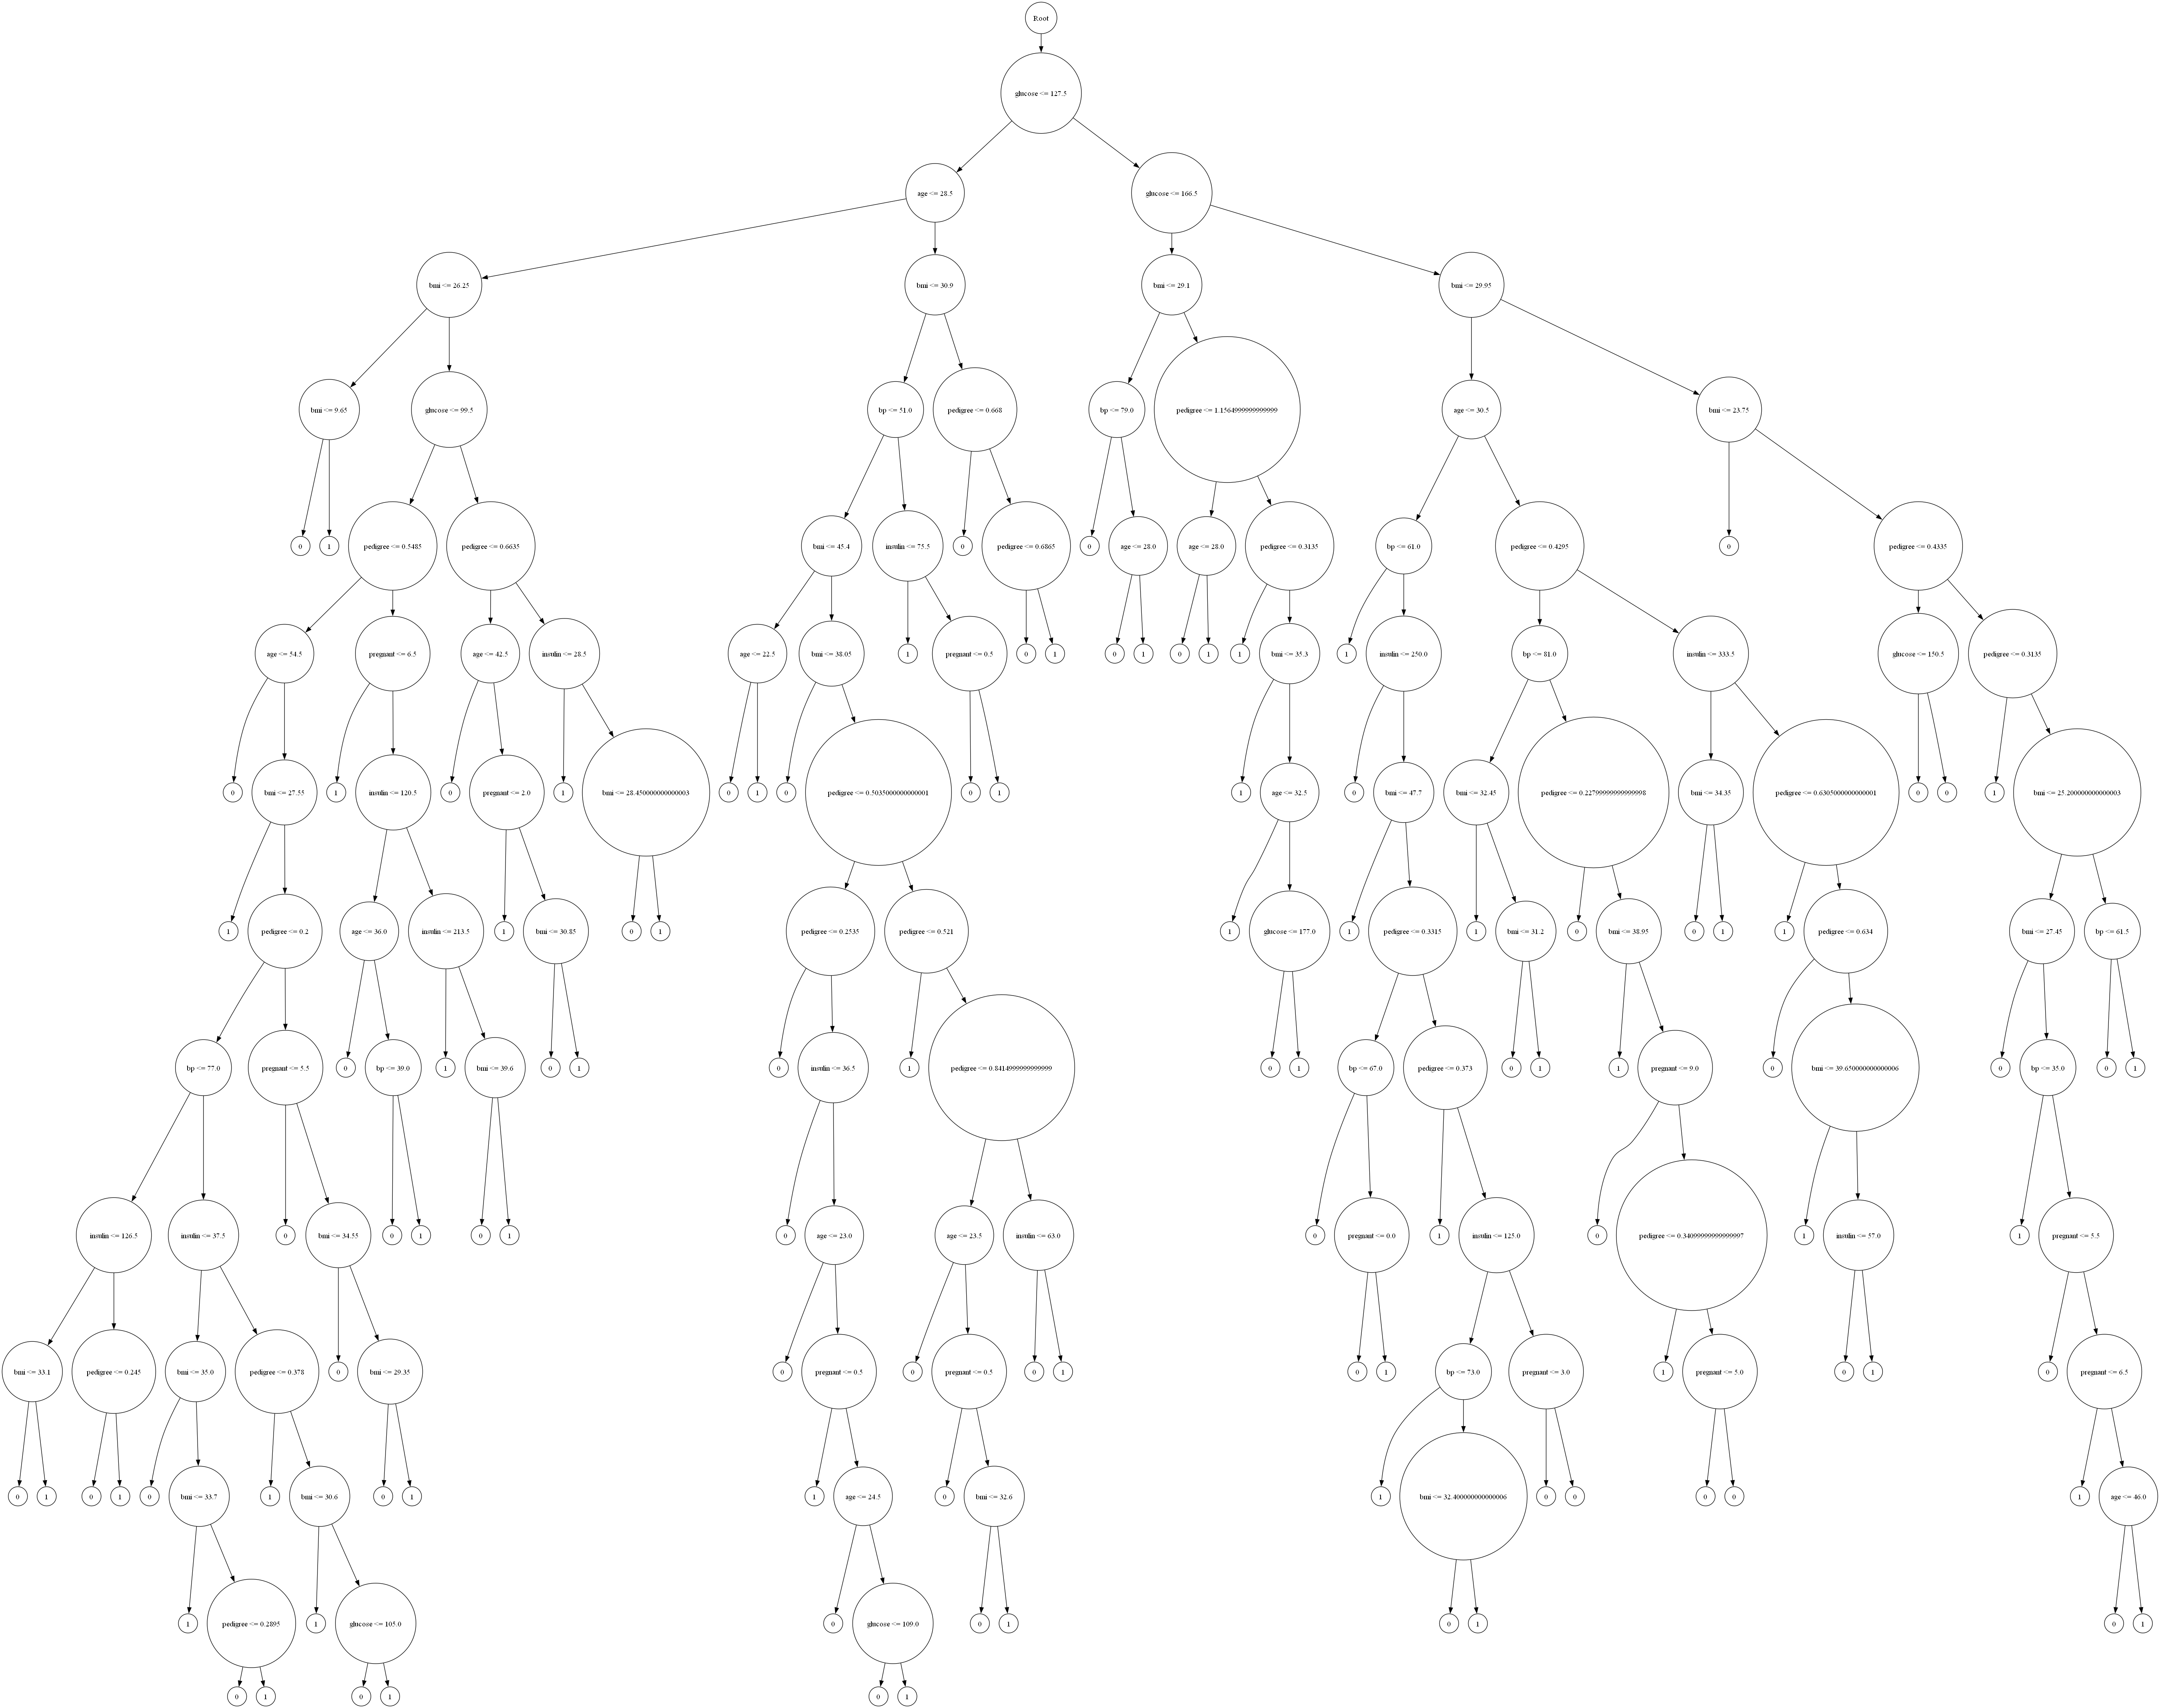

In [686]:

tree.to_graphviz("tree")

pydot_graph = pydotplus.graph_from_dot_file("tree")
from IPython.display import Image

Image(pydot_graph.create_png())


In [354]:
# Lets Test If our implementation is working correly\
# We will be using sklearns Decision Tree and compare the output with ours

In [687]:

def predict(node,feature_names,  x):
    global tree


    if node.is_leaf():

       
        return node.tag

    else:
        node_identifier = node.identifier
        node_tag = node.tag
        node_name = node_tag.replace("<="," ").split()
        
        column_name = str(node_name[0])
        condition = node_name[1]

        
       
        
        try:
          left_node ,right_node = tree.is_branch(node_identifier)
         
          

          if(left_node is None or right_node is None )==True:

              node_now = tree.is_branch(node_identifier)
              node = tree[node_now]
              node_tag = predict(node, x) 

          else:
              left_node = tree[left_node]
              right_node = tree[right_node]
            
              column_pos =  feature_names.index(column_name)
             
              
              if(float(x[column_pos])<= float(condition))==True:
                   
                   node_tag = predict(left_node,feature_names, x) 
              else:
                   node_tag = predict(right_node,feature_names, x)   

        except:
            print("God knows what")
    return node_tag
         
          

       
              


In [688]:
def accuracy(x, y, feature_names, node):
    
   
    if node==0:
        node  =tree.is_branch(0)
        node = tree[node[0]]
  
    valid = 0
    
    for i in range(0,len(y)):
    
        
        prediction = predict(node, feature_names, x[i])
       
        if str(prediction) == str(y[i]):
            valid +=1
       
    
    percentage =  (valid / len(y))*100

    return percentage


In [691]:
accuracy(x_test, y_test,feature_names, 0)

70.77922077922078

In [289]:
# Scikit Learns Library function starts here
# You can remove it if you want

In [692]:

import pandas as pd
from sklearn.tree import DecisionTreeClassifier 

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy")

# Train Decision Tree Classifer
clf = clf.fit(x_train,y_train)




In [693]:
y_pred = clf.predict(x_test)

In [694]:
accuracy_score(y_test, y_pred)


0.7467532467532467

In [ ]:
# Our was 0.70 so I think it's acceptable. The different may happend due to  optimization like post/pre pruining. 

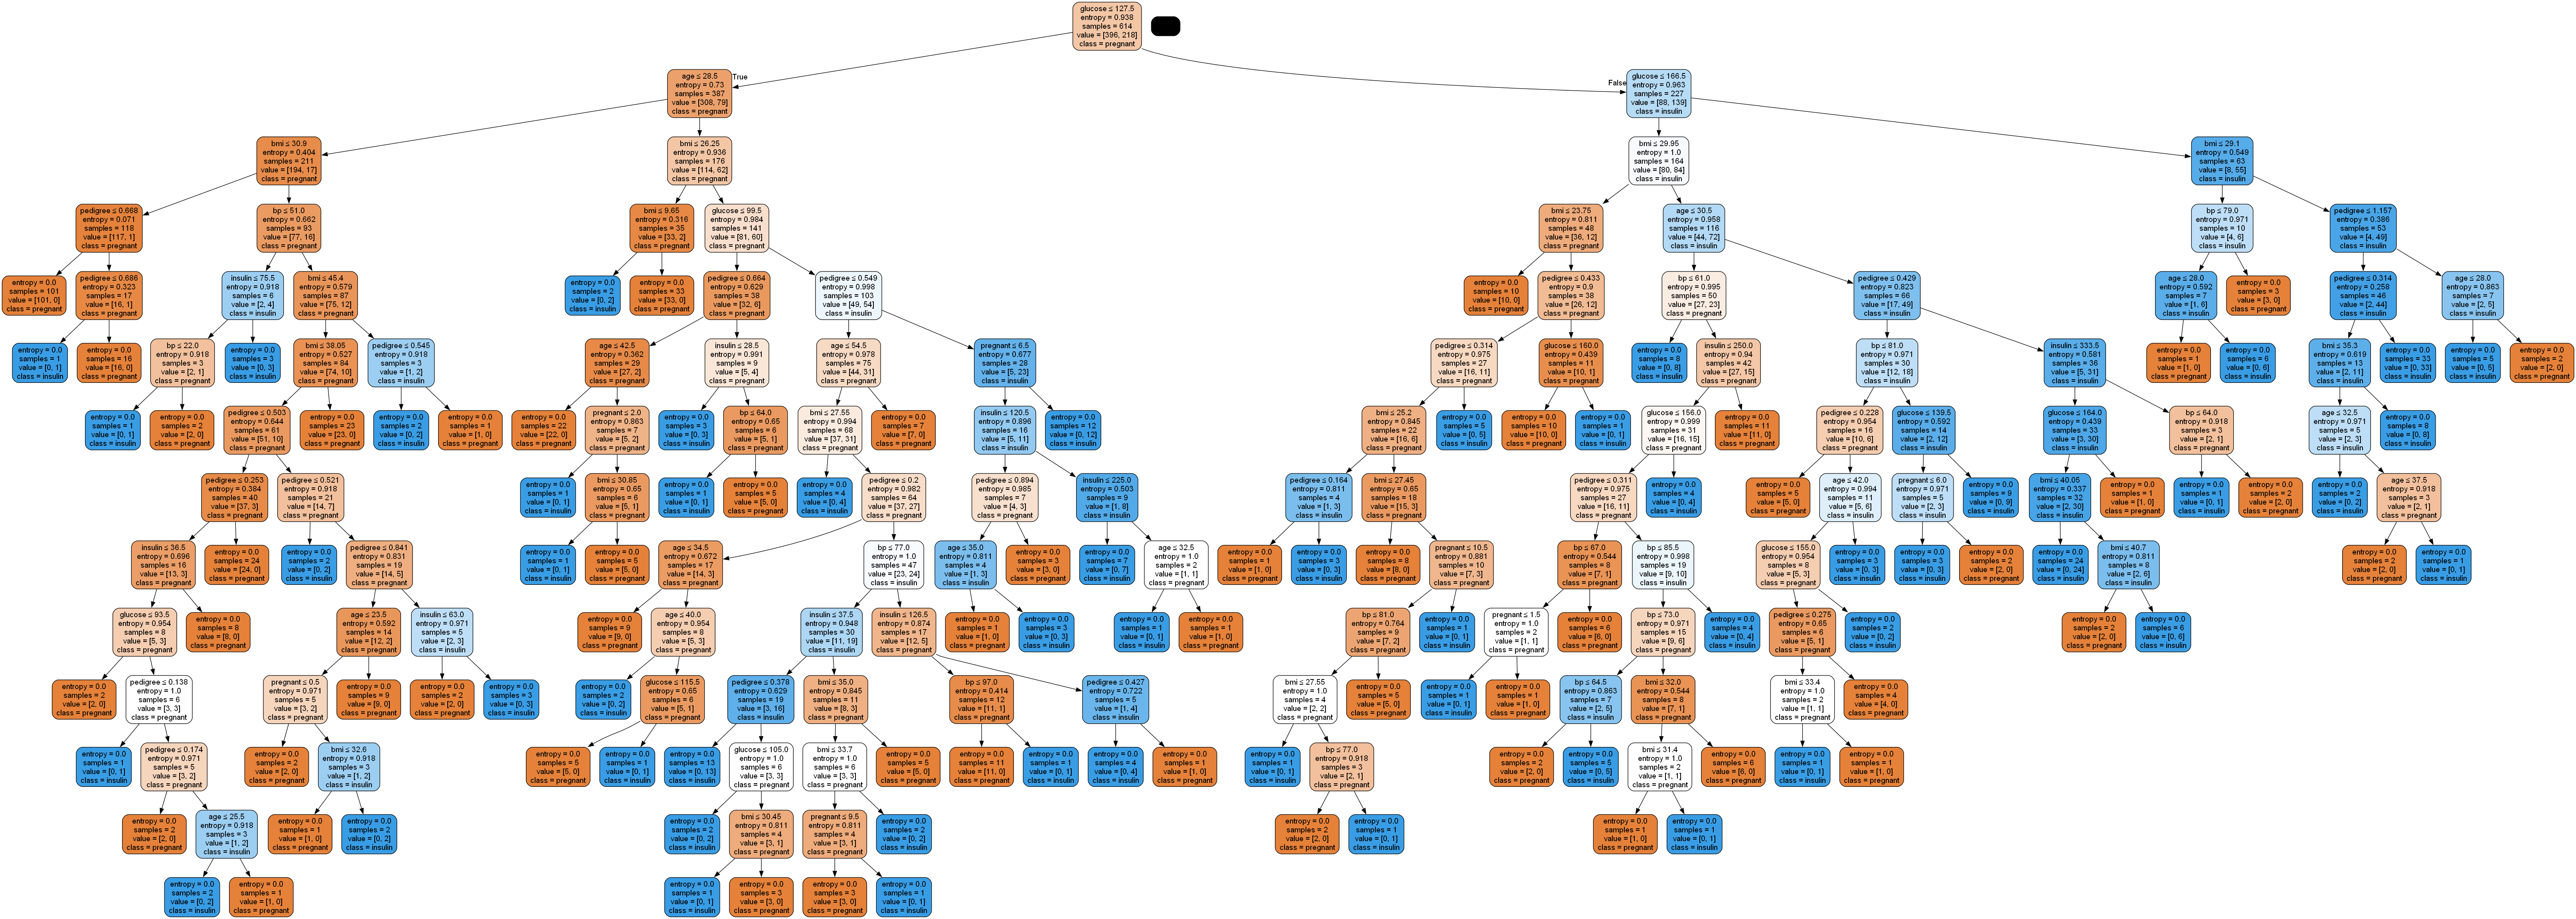

In [696]:
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_names,class_names=feature_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())